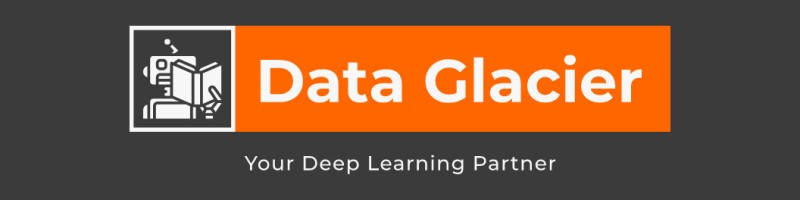


## Task:

* Take any csv/text file of 2+ GB of your choice. --- (You can do this assignment on Google colab)

* Read the file ( Present approach of reading the file )

* Try different methods of file reading eg: Dask, Modin, Ray, pandas and present your findings in term of computational     efficiency

* Perform basic validation on data columns : eg: remove special character , white spaces from the col name

* As you already know the schema hence create a YAML file and write the column name in YAML file. --define separator of   
  read and write file, column name in YAML

* Validate number of columns and column name of ingested file with YAML.

* Write the file in pipe separated text file (|) in gz format.

* Create a summary of the file:

    Total number of rows,

    total number of columns

    file size
    
# Data Ingestion sample code walkthrough

## 
  > Create a utility file
  
  > Config file creation
  
  > Data ingestion pipeline


In [1]:
%%writefile testutility.py
import logging
import os
import subprocess
import yaml
import pandas as pd
import datetime 
import gc
import re


################
# File Reading #
################

def read_config_file(filepath):
    with open(filepath, 'r') as stream:
        try:
            return yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            logging.error(exc)


def replacer(string, char):
    pattern = char + '{2,}'
    string = re.sub(pattern, char, string) 
    return string

def col_header_val(df,table_config):
    '''
    replace whitespaces in the column
    and standardized column names
    '''
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace('[^\w]','_',regex=True)
    df.columns = list(map(lambda x: x.strip('_'), list(df.columns)))
    df.columns = list(map(lambda x: replacer(x,'_'), list(df.columns)))
    expected_col = list(map(lambda x: x.lower(),  table_config['columns']))
    expected_col.sort()
    df.columns =list(map(lambda x: x.lower(), list(df.columns)))
    df = df.reindex(sorted(df.columns), axis=1)
    if len(df.columns) == len(expected_col) and list(expected_col)  == list(df.columns):
        print("column name and column length validation passed")
        return 1
    else:
        print("column name and column length validation failed")
        mismatched_columns_file = list(set(df.columns).difference(expected_col))
        print("Following File columns are not in the YAML file",mismatched_columns_file)
        missing_YAML_file = list(set(expected_col).difference(df.columns))
        print("Following YAML columns are not in the file uploaded",missing_YAML_file)
        logging.info(f'df columns: {df.columns}')
        logging.info(f'expected columns: {expected_col}')
        return 0

Overwriting testutility.py


### Write YAML file

In [2]:
%%writefile file.yaml
file_type: csv
dataset_name: prebp400021
file_name: prebp400021
inbound_delimiter: ","
outbound_delimiter: "|"
skip_leading_rows: 1
columns: 
 -Athlete
 -Baseline_age
 -Baseline_sex
 -Baseline_height
 -Baseline_mass
 -Baseline_discipline


Overwriting file.yaml


In [3]:
# Read config file
import testutility as util
config_data = util.read_config_file("file.yaml")

In [4]:
config_data['inbound_delimiter']

','

In [5]:
#inspecting data of config file
config_data

{'file_type': 'csv',
 'dataset_name': 'prebp400021',
 'file_name': 'prebp400021',
 'inbound_delimiter': ',',
 'outbound_delimiter': '|',
 'skip_leading_rows': 1,
 'columns': '-Athlete -Baseline_age -Baseline_sex -Baseline_height -Baseline_mass -Baseline_discipline'}

In [6]:
# Normal reading process of the file
import pandas as pd
df_sample = pd.read_csv("prebp400021.csv",delimiter=',')
df_sample.head()

Athlete  Baseline_age  Baseline_sex  Baseline_height  Baseline_mass  \
0        1         14.45             0              174             60   
1        1         14.45             0              174             60   
2        1         14.45             0              174             60   
3        1         14.45             0              174             60   
4        1         14.45             0              174             60   

   Baseline_discipline  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0

In [7]:
# read the file using config file
file_type = config_data['file_type']
source_file = "./" + config_data['file_name'] + f'.{file_type}'
#print("",source_file)
df = pd.read_csv(source_file,config_data['inbound_delimiter'])
df.head()

/home/fatemeh/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3397: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  exec(code_obj, self.user_global_ns, self.user_ns)


Athlete  Baseline_age  Baseline_sex  Baseline_height  Baseline_mass  \
0        1         14.45             0              174             60   
1        1         14.45             0              174             60   
2        1         14.45             0              174             60   
3        1         14.45             0              174             60   
4        1         14.45             0              174             60   

   Baseline_discipline  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0

In [8]:
#validate the header of the file
util.col_header_val(df,config_data)

column name and column length validation failed
Following File columns are not in the YAML file ['athlete', 'baseline_discipline', 'baseline_height', 'baseline_mass', 'baseline_sex', 'baseline_age']
Following YAML columns are not in the file uploaded ['i', 'c', 'a', 'g', 't', 'h', 'n', 'p', 'm', '_', 'd', 's', ' ', 'x', 'b', 'e', 'l', '-']


0

In [9]:
print("columns of files are:" ,df.columns)
print("columns of YAML are:" ,config_data['columns'])

columns of files are: Index(['athlete', 'baseline_age', 'baseline_sex', 'baseline_height',
       'baseline_mass', 'baseline_discipline'],
      dtype='object')
columns of YAML are: -Athlete -Baseline_age -Baseline_sex -Baseline_height -Baseline_mass -Baseline_discipline


In [10]:
if util.col_header_val(df,config_data)==0:
    print("validation failed")
    # write code to reject the file
else:
    print("col validation passed")
    # write the code to perform further action
    # in the pipleine

column name and column length validation failed
Following File columns are not in the YAML file ['athlete', 'baseline_discipline', 'baseline_height', 'baseline_mass', 'baseline_sex', 'baseline_age']
Following YAML columns are not in the file uploaded ['i', 'c', 'a', 'g', 't', 'h', 'n', 'p', 'm', '_', 'd', 's', ' ', 'x', 'b', 'e', 'l', '-']
validation failed


In [11]:
pd.read_csv("./prebp400021.csv")

Athlete  Baseline_age  Baseline_sex  Baseline_height  Baseline_mass  \
0          1         14.45             0              174             60   
1          1         14.45             0              174             60   
2          1         14.45             0              174             60   
3          1         14.45             0              174             60   
4          1         14.45             0              174             60   
..       ...           ...           ...              ...            ...   
194        5         34.00             0              175             62   
195        6         23.79             1              173             56   
196        6         23.79             1              173             56   
197        6         23.79             1              173             56   
198        6         23.79             1              173             56   

     Baseline_discipline  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  
..                   ...  
194                    1  
195                    3  
196                    3  
197                    3  
198                    3  

[199 rows x 6 columns]

In [12]:
df

athlete  baseline_age  baseline_sex  baseline_height  baseline_mass  \
0          1         14.45             0              174             60   
1          1         14.45             0              174             60   
2          1         14.45             0              174             60   
3          1         14.45             0              174             60   
4          1         14.45             0              174             60   
..       ...           ...           ...              ...            ...   
194        5         34.00             0              175             62   
195        6         23.79             1              173             56   
196        6         23.79             1              173             56   
197        6         23.79             1              173             56   
198        6         23.79             1              173             56   

     baseline_discipline  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  
..                   ...  
194                    1  
195                    3  
196                    3  
197                    3  
198                    3  

[199 rows x 6 columns]

In [13]:
### Creating test file for this demo:
testdata = {
    'Athlete' : [1],
    'Baseline_age' : [14.45],
}
import pandas as pd
df = pd.DataFrame(testdata, columns=['Athlete', 'Baseline_age'])
df.to_csv("prebp400021.csv",index=False)

In [14]:
df

city  baseline_age
0  NaN         14.45

In [15]:
testdata


{'Athlete': [1], 'baseline_age': [14.45]}